In [1]:
%load_ext autoreload
%autoreload 2

# first we need a bit of import boilerplate
import os
import sys
from sys import platform
if platform == 'win32':
    sys.path.append('D:/Brain_Network/Code/')
    manifest_path = 'D:/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = 'D:/Brain_Network/'
elif platform =='darwin':
    sys.path.append('/Users/chenyu/Workspace/Brain_Network/Code/')
    manifest_path = '/Users/chenyu/Workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/Users/chenyu/Workspace/Brain_Network/'
elif platform == 'linux':
    sys.path.append('/home/yuchen/workspace/Brain_Network/Code/')
    manifest_path = '/home/yuchen/workspace/Brain_Network/Data/Allen_Institute_Dataset/manifest.json'
    project_dir = '/home/yuchen/workspace/Brain_Network/'
else:
    print('Add new computer system settings.')

import numpy as np; np.set_printoptions(linewidth=110);
import glob
import pandas as pd
import matplotlib.pyplot as plt
# import seaborn
import scipy
import scipy.io as sio
from scipy.ndimage.filters import gaussian_filter
import seaborn
from tqdm.notebook import trange
import time

from allensdk.brain_observatory.ecephys.ecephys_project_cache import EcephysProjectCache
from allensdk.brain_observatory.ecephys.ecephys_session import EcephysSession

# tell pandas to show all columns when we display a DataFrame
pd.set_option("display.max_columns", None)

import hierarchical_model_generator
import hierarchical_sampling_model

In [2]:
import pandas as pd
print('pd', pd.__version__)
import allensdk
print('allensdk', allensdk.__version__)
import h5py
print('h5py', h5py.__version__)
import pynwb
print('pynwb', pynwb.__version__)
import hdmf
print('hdmf', hdmf.__version__)

pd 1.1.1
allensdk 2.2.0
h5py 2.8.0
pynwb 1.4.0
hdmf 2.2.0


# Hierarchical model Generator

### Load tamplate model

In [3]:
model_files = [
'HBM_checkpoint_B_MC_0_500ms_probeCE_condition1_20200813-092937_generator_template.pkl', # B
'HBM_checkpoint_BSS_MC_0_500ms_probeCE_o225_270_f8_20200801-174224_generator_template.pkl', # BSS A2
'HBM_checkpoint_BSS_MC_0_500ms_probeCDE_o225_270_f8_20200731-125456_generator_template.pkl',
'798911424_checkpoints_batch10_20200910-194436_generator_template.pkl'] # BSS A3

In [4]:

def runner(random_seed):

    print(f'---------------------- {random_seed} --------------------')
    ## Load simulation
    generator_model = hierarchical_model_generator.HierarchicalModelGenerator()
    data_folder = project_dir + 'Output/simulation/'
    file_path = (data_folder + model_files[0])
    generator_model.load_model(file_path)

    np.random.seed(random_seed)  # Random seed for pseudo data.
    model_feature_type = 'B'
    generator_model.initial_step(model_feature_type=model_feature_type, num_trials=30, num_conditions = 1)

    ## Generate data
    generator_model.generate_mu_sigma(sample_type='fixed', verbose=False)
    generator_model.generate_q()
    generator_model.generate_f_pop_gac(select_clist=[0], same_as_cross=False, verbose=False)
    generator_model.generate_z(verbose=False)
    generator_model.generate_p_gac(verbose=False)
    generator_model.generate_log_lambda_nargc(verbose=False)
    generator_model.generate_spikes(verbose=False)

    ## Prepare for the data fitting.
    trial_time_window=generator_model.trial_time_window
    spike_train_time_line = generator_model.spike_train_time_line
    spike_trains, spike_times = generator_model.spike_trains, generator_model.spike_times
    session = None
    spike_counts, spike_shifts = generator_model.spike_counts, generator_model.spike_shifts
    units_probes = generator_model.selected_units['probe_description']
    probes = generator_model.probes
    selected_units = generator_model.selected_units
    trials_indices = generator_model.trials_indices
    trials_groups = generator_model.trials_groups

    ## Initial HBM
    np.random.seed(0)  # Random seed for MCMC chain.
    model = hierarchical_sampling_model.HierarchicalSamplingModel(session)
    model.initial_step(spike_trains, spike_times, spike_train_time_line, selected_units, trials_groups,
                       trial_time_window, probes=['probeC', 'probeE'], num_areas=2, num_groups=3, 
                       model_feature_type=model_feature_type, prior_type='diag',
                       eta_smooth_tuning=4e-8, verbose=False)

    ##
    clist = [0]
    thin_begin = 0
    thin_step = 1

    t = trange(0, 1500)
    for itr in t:
        slc = (itr >= thin_begin) and (itr % thin_step == 0)
        for c in clist:
            if itr < 150:
                model.update_f_local_pop_cag(c, sample_type='fit', verbose=False)
                model.update_f_cross_pop_ca(c, sample_type='fit', record=(c==clist[-1] and slc), verbose=False)
            elif itr >= 150:
                model.update_f_local_pop_cag(c, sample_type='sample', verbose=False)
                model.update_f_cross_pop_ca(c, sample_type='sample', record=(c==clist[-1] and slc), verbose=False)

            if itr < 15:
                model.update_q_arc(c, sample_type='fit', fit_peak_ratio=0,
                                   record=(c==clist[-1] and slc), verbose=False)
            if (itr >= 15) and (itr < 30):  # Fit peaks.
                model.update_q_arc(c, sample_type='fit', fit_peak_ratio=0.01,
                                   record=(c==clist[-1] and slc), verbose=False)
            if itr >= 30:
                model.update_q_arc(c, sample_type='sample', proposal_scalar=0.1, fit_peak_ratio=0,
                                   record=(c==clist[-1] and slc), verbose=False)
            if itr >= 60 and (itr % 10 == 0):
                model.update_z_ngac(c, sample_type='sample', 
                                    record=(c==clist[-1]), verbose=False)
            if itr >= 60:
                model.update_p_gac(c, sample_type='sample',
                                   record=(c==clist[-1] and slc), verbose=False)

        if itr >= 60:
            model.update_mu_simga(clist=clist, sample_type='iw_sample', record=slc, verbose=False)
        model.complete_log_likelihood(clist)
        t.set_description(f'log-likelihood: {model.samples.log_likelihood[-1]:.2f}')

    ## Output
    model.samples.plot_log_likelihood()
    model.samples.plot_marginal_correlation(0, 1, burn_in=0, end=-1, step=1, plot_type='rho',
            true_model=generator_model, model_feature_type=model.model_feature_type,
            distribution_type='none')

    # Save data.
    experiment_name = (f'{model_feature_type}_0_500ms_probe2_R{len(trials_indices)}_' + 
                       f'sim_thinbegin{thin_begin}_thinstep{thin_step}_')
    timestr = time.strftime("%Y%m%d-%H%M%S")
    output_folder = project_dir + 'Output/simulation_output/B_A2_R30_diag_prior_fixed_sigma_df3/'

    # Save estimated model.
    prefix = f'HBM_checkpoint_seed{random_seed}_'
    file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
    model.save_model(save_data=False, file_path=file_path)
    # Save true model.
    prefix = f'HBM_generator_seed{random_seed}_'
    file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
    generator_model.save_data(save_spikes=False, file_path=file_path)
    # Save samples.
    prefix = f'HBM_samples_seed{random_seed}_'
    file_path = output_folder + prefix + experiment_name + timestr + '.pkl'
    model.samples.save(file_path)

---------------------- 53 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeE g:[2 1 0] counts:[37 30 22]  


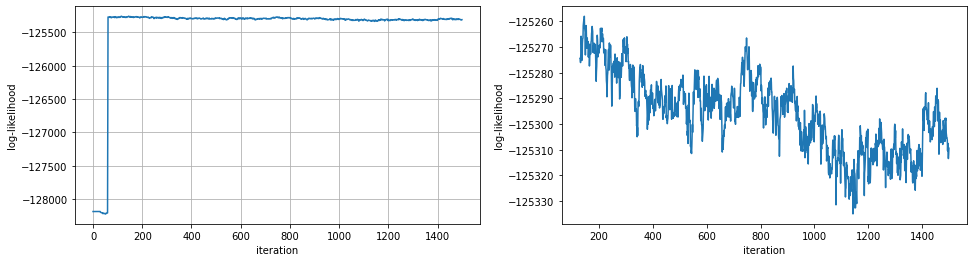

sigma_samples.shape: (1440, 2, 2)
z values: 0.838712575118468 0.18563432298137125


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


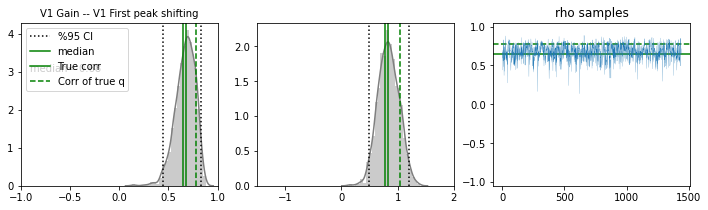

---------------------- 54 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeE g:[2 1 0] counts:[36 31 22]  


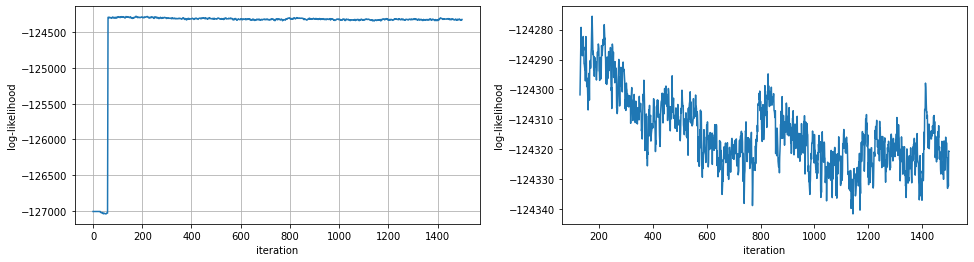

sigma_samples.shape: (1440, 2, 2)
z values: 0.5377514821200459 0.1861953315798114


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


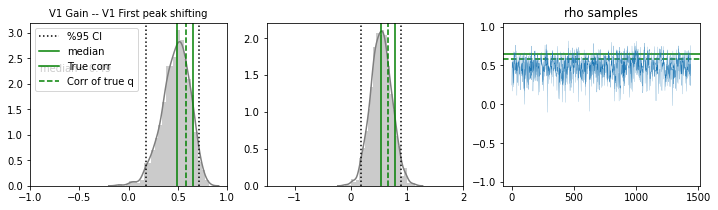

---------------------- 55 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 34 21]  probeE g:[2 1 0] counts:[36 31 22]  


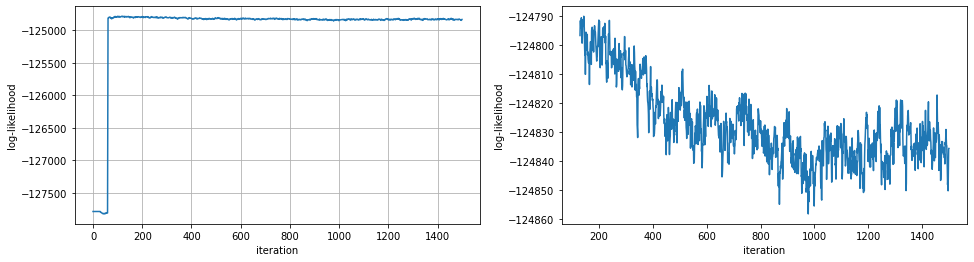

sigma_samples.shape: (1440, 2, 2)
z values: 0.6166361268943824 0.18846603533179063


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


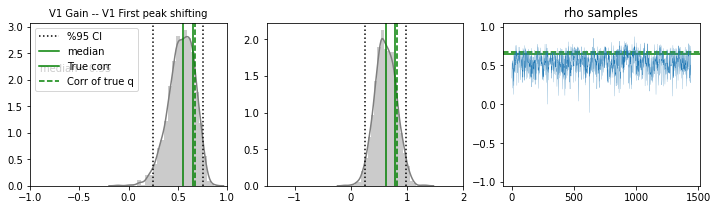

---------------------- 56 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeE g:[2 1 0] counts:[36 31 22]  


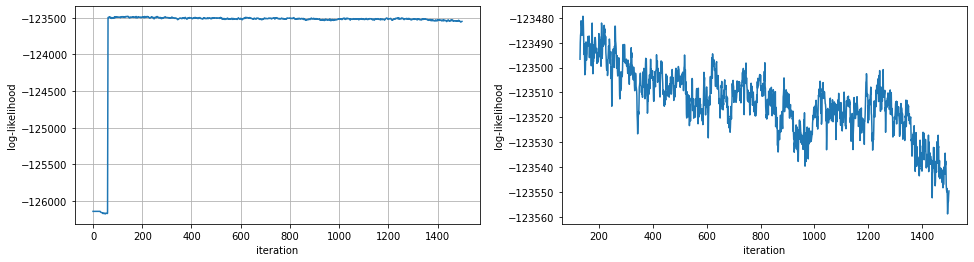

sigma_samples.shape: (1440, 2, 2)
z values: 0.6494145745027439 0.187223058602484


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


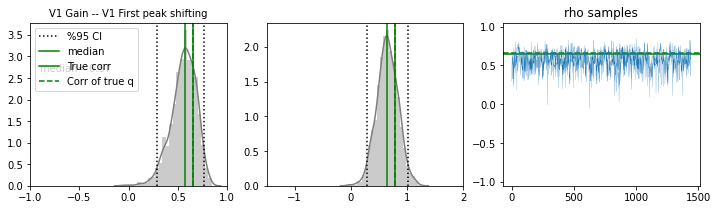

---------------------- 57 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 33 22]  probeE g:[2 1 0] counts:[36 31 22]  


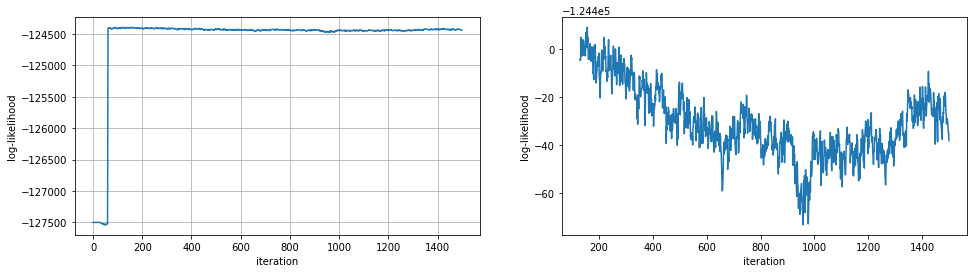

sigma_samples.shape: (1440, 2, 2)
z values: 0.7208015055830594 0.18715947158558113


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


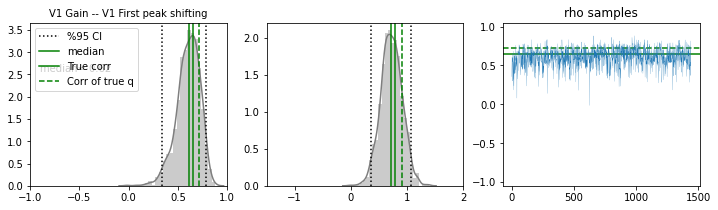

---------------------- 58 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeE g:[2 1 0] counts:[36 31 22]  


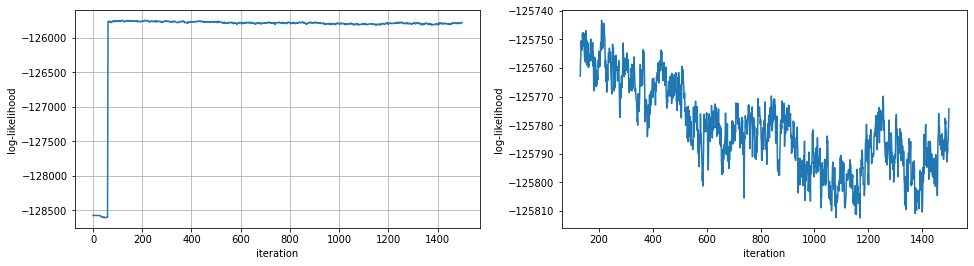

sigma_samples.shape: (1440, 2, 2)
z values: 0.8592883836262436 0.18460696873695


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


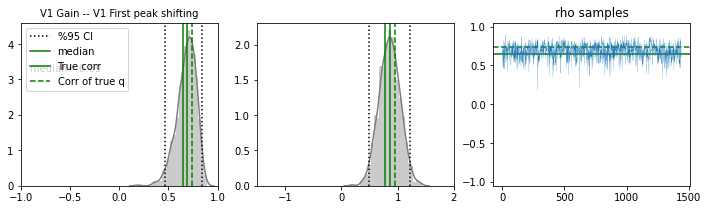

---------------------- 59 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 32 23]  probeE g:[2 1 0] counts:[36 31 22]  


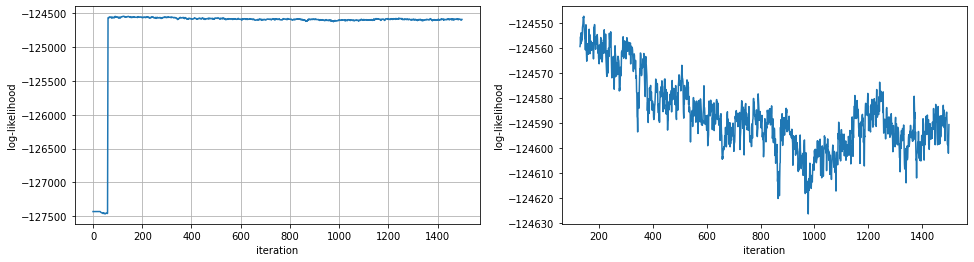

sigma_samples.shape: (1440, 2, 2)
z values: 0.6536493677392332 0.1850832257212567


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


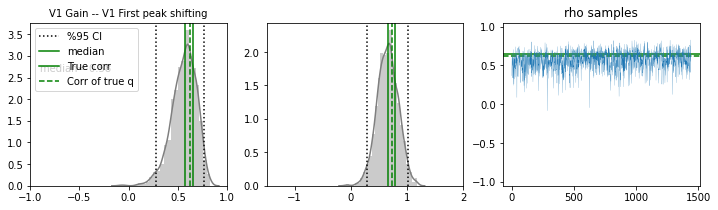

---------------------- 60 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[40 30 24]  probeE g:[2 1 0] counts:[36 31 22]  


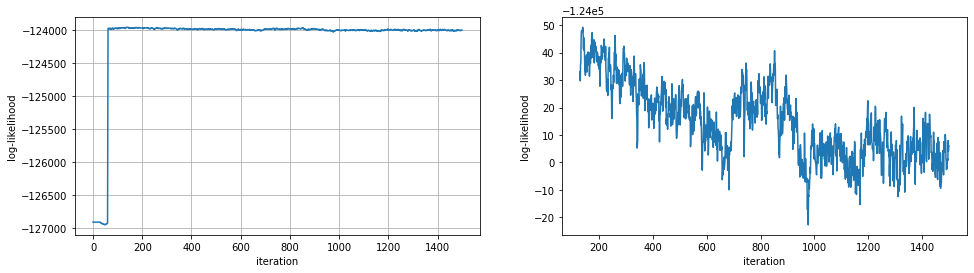

sigma_samples.shape: (1440, 2, 2)
z values: 0.6732695528073218 0.1862408997447983


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


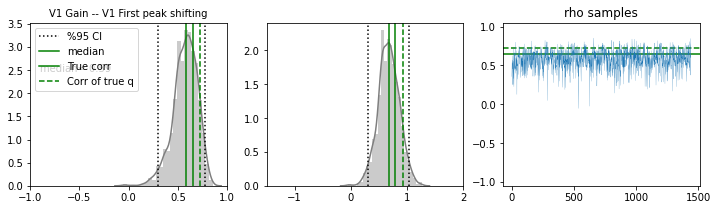

---------------------- 61 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeE g:[2 1 0] counts:[36 31 22]  


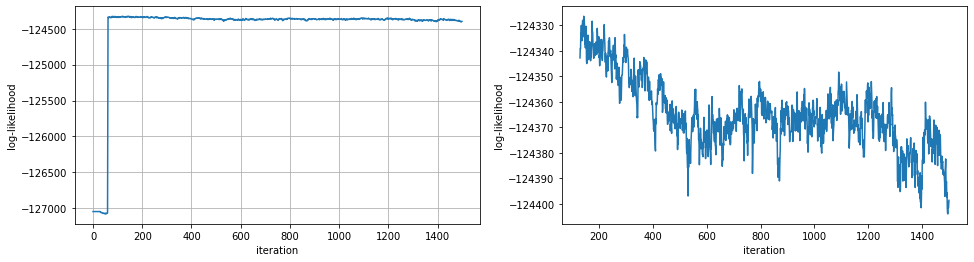

sigma_samples.shape: (1440, 2, 2)
z values: 0.6580594464605871 0.1867774188021789


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


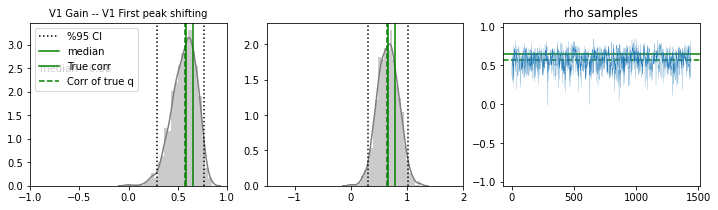

---------------------- 62 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeE g:[2 1 0] counts:[37 30 22]  


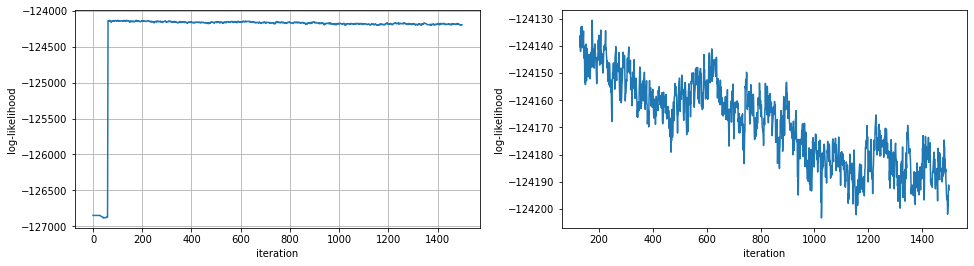

sigma_samples.shape: (1440, 2, 2)
z values: 0.5908193998510962 0.18998476386336144


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


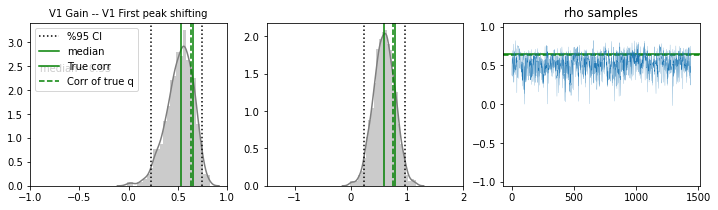

---------------------- 63 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 33 23]  probeE g:[2 1 0] counts:[36 31 22]  


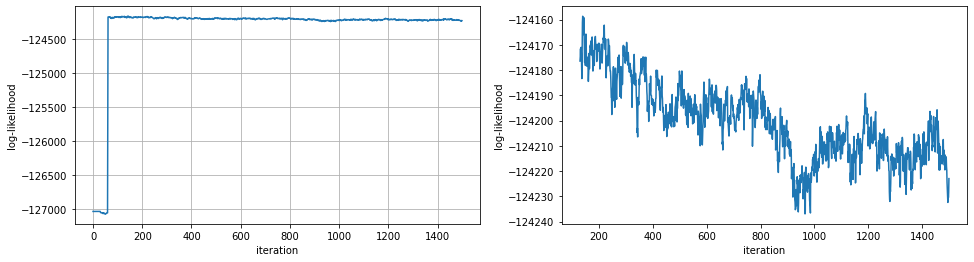

sigma_samples.shape: (1440, 2, 2)
z values: 0.4810743069426536 0.19001760026311124


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


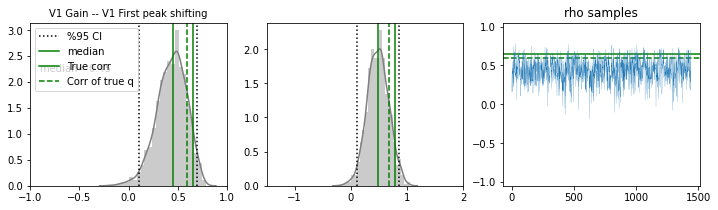

---------------------- 64 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeE g:[2 1 0] counts:[36 31 22]  


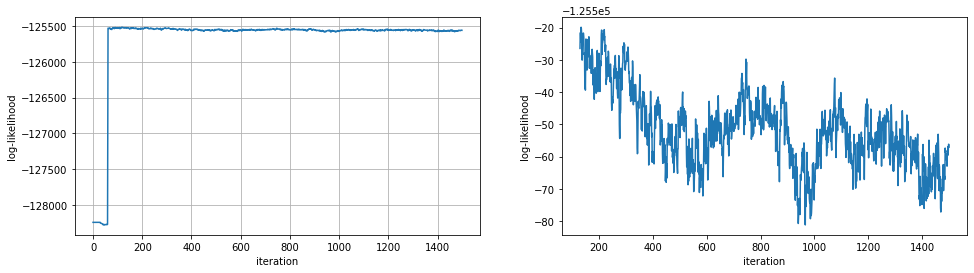

sigma_samples.shape: (1440, 2, 2)
z values: 0.6837504917108348 0.18702398528272815


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


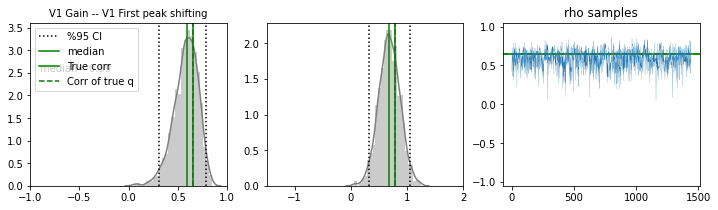

---------------------- 65 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeE g:[2 1 0] counts:[37 30 22]  


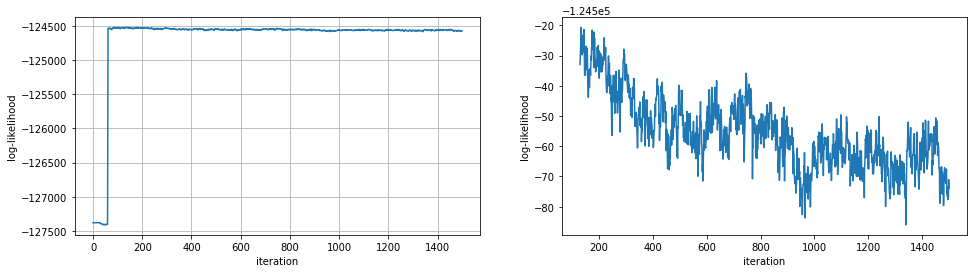

sigma_samples.shape: (1440, 2, 2)
z values: 0.6711484560143132 0.18783237169248698


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


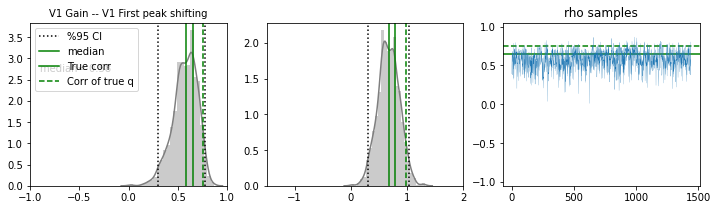

---------------------- 66 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[39 31 24]  probeE g:[2 1 0] counts:[36 31 22]  


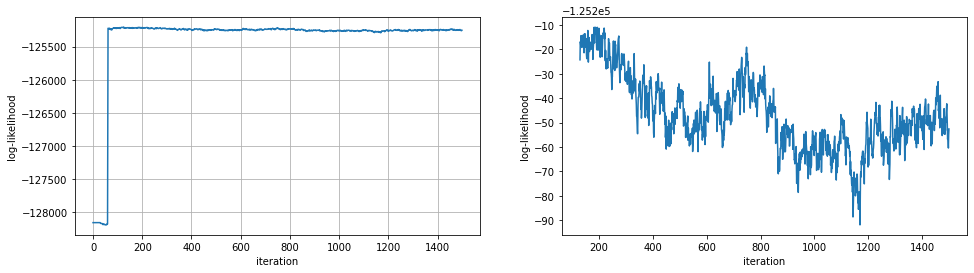

sigma_samples.shape: (1440, 2, 2)
z values: 0.7301168987682521 0.18547086984000752


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


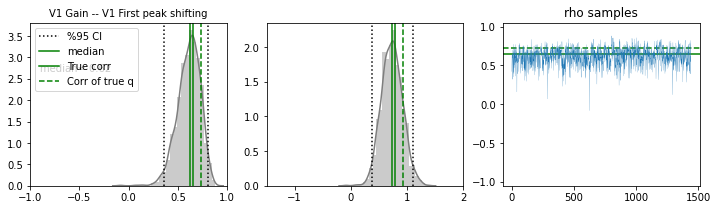

---------------------- 67 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[41 29 24]  probeE g:[2 1 0] counts:[37 31 21]  


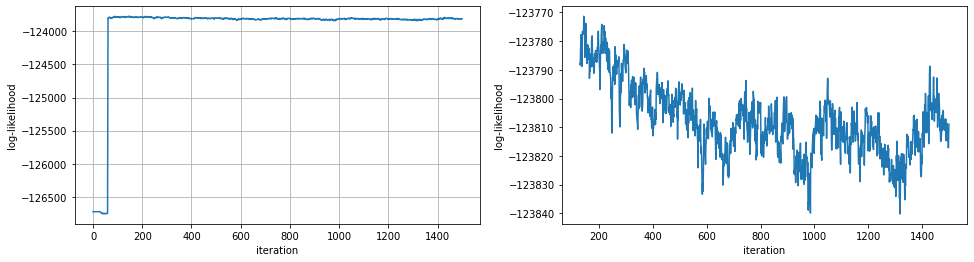

sigma_samples.shape: (1440, 2, 2)
z values: 0.5502405876686004 0.18820321659302938


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


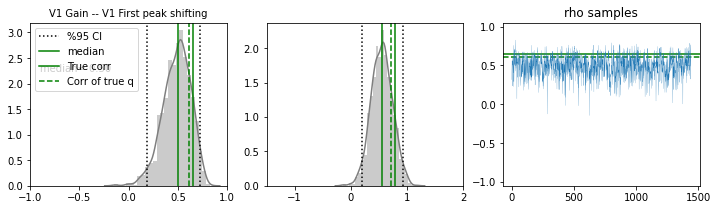

---------------------- 68 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[40 30 24]  probeE g:[2 1 0] counts:[36 31 22]  


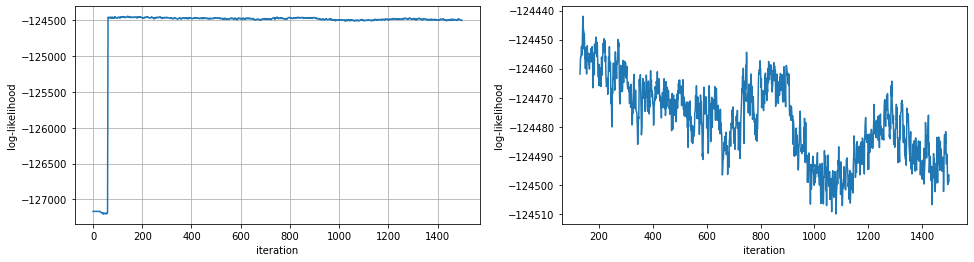

sigma_samples.shape: (1440, 2, 2)
z values: 0.588633501163567 0.1873973107376845


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


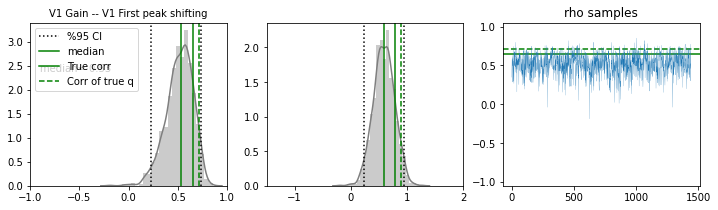

---------------------- 69 --------------------
model_feature_type: B

num areas 2   num trials 30   num conditions 1   num qs 1
Model feature type:  B
Condition: 0  stimulus_condition_id:0.0
probeC g:[2 1 0] counts:[38 32 24]  probeE g:[2 1 0] counts:[36 32 21]  


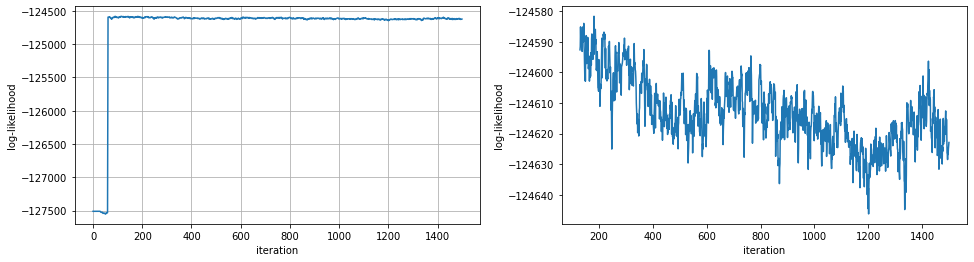

sigma_samples.shape: (1440, 2, 2)
z values: 0.4715759788103783 0.18689160790745035


D:/Brain_Network/Code\util.py:491: RuntimeWarning: divide by zero encountered in true_divide
  z = 0.5 * np.log((1 + rho) / (1 - rho))


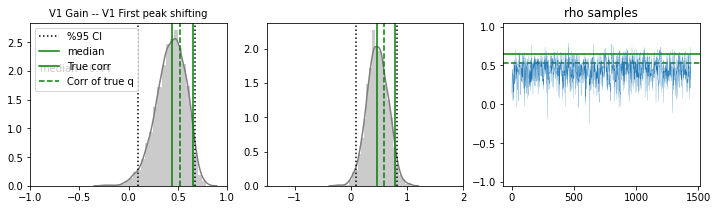

In [5]:
seed_range = trange(53, 70)
for random_seed in seed_range:
    runner(random_seed)